In [1]:
# This section of the code is for all of my imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
from datetime import datetime

# This allows me to access my flash drive that im working off of
os.chdir('/Volumes/Flash Drive')

In [2]:
# This section allows you to analysis Different CSV Files
Path = '/Volumes/Flash Drive/Saturns rings Research/Data From Center of Ringlets CSV files/'
# ===== CHANGE THIS TO ANALYZE DIFFERENT CSV FILES =====
CSV = 'BetCen_104I_1km_ringlet_medians'
# ==========================================================
Type = '.csv'
CSV_file = Path + CSV + Type

In [3]:
# This Section is the formulas to convert from UTC to ET time, im working off of ET time

# This formula gets the UTC and ET offset due to leap seconds, number is in seconds
def utc_to_et_offset(year):
    """
    Get the offset between UTC and ET (TDB) in seconds for 2008.
    
    For 2008:
    - Leap seconds accumulated by 2008: 33 seconds
    - TT-TAI offset: 32.184 seconds
    - ET ≈ TDB ≈ TT for most purposes
    - So ET - UTC ≈ 33 + 32.184 = 65.184 seconds
    """
    
    ls = 33  # Leap Seconds since 2008

    # TT - TAI offset is always 32.184 seconds
    tt_tai_offset = 32.184
    
    # ET ≈ TDB ≈ TT = UTC + leap_seconds + 32.184
    et_utc_offset = ls + tt_tai_offset
    
    return et_utc_offset # Seconds

# This section of the code converts the UTC Julian Date to ET Julian Date adding in the leap seconds offset
def convert_paper_time_to_et(jd_utc):
    """
    Convert the paper's UTC-based Julian Date to ET-based Julian Date.
    
    Parameters:
    -----------
    jd_utc : float
        Julian Date in UTC (as used in the paper)
    
    Returns:
    --------
    jd_et : float
        Julian Date in Ephemeris Time
    """
    
    # Get offset for 2008
    et_utc_offset_2008 = utc_to_et_offset(2008)
    
    # Convert to ET
    initial_time = jd_utc + (et_utc_offset_2008 / 86400.0)
    
    return initial_time # Seconds


In [4]:
# This section defines the True Anamoly formula and the radius formula

def calculate_radius_true_anomaly(a, e, true_anomaly):
    """
    Calculate the radius at a given true anomaly for a Keplerian ellipse.
    
    This implements equation (2) from the paper:
    r(λ,t) = a(1 - e²) / (1 + e·cos(f))
    f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    a : float
        Semi-major axis (km)
    e : float
        Eccentricity (dimensionless, between 0 and 1)
    true_anomaly : float or array
        True anomaly f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
        where λ is the inertial longitude and ϖ is the longitude of periapse
    
    Returns:
    --------
    r : float or array
        Radius at the given true anomaly (km)
    """

        # Convert to radians
    #true_anomaly = true_anomaly * np.pi / 180
    
    # Calculate the numerator: a(1 - e²)
    numerator = a * (1 - e**2)
    
    # Calculate the denominator: 1 + e·cos(f)
    denominator = 1 + e * np.cos(true_anomaly)
    
    # Calculate radius
    r = numerator / denominator
    
    return r

def calculate_true_anomaly(longitude #Inertial longitude (LON value)
                           ,varpi_0 # Longitude periapse (Fixed)
                           ,varpi_dot #Rrecession rate (Fixed)
                           ,time # Time from data
                           ,initial_time): # Time from paper (fixed)
    """
    Calculate the true anomaly from orbital parameters.
    
    From the paper: f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    longitude : float or array
        Inertial longitude λ (degrees)
    varpi_0 (Longitude periapse) : float
        Longitude of periapse at epoch ϖ₀ (degrees)
    varpi_dot (precession rate) : float, optional
        Apsidal precession rate ϖ̇ (degrees/day)
    time : float, optional
        Current time (days)
    initial_time : float, optional
        Epoch time t₀ (days)
    
    Returns:
    --------
    true_anomaly : float or array
        True anomaly f (degrees)
    """
    
    # True anomaly is the angle from periapse
    true_anomaly = longitude - varpi_0 - varpi_dot * (time - initial_time)

    # Wrap to 0-360 degrees
    true_anomaly = true_anomaly % 360
    
    return true_anomaly

def plot_r_vs_true_anomaly(true_anomaly, radii, title=f"\Radius vs True Anomaly Analysis of Titan Ringlet \n File: {CSV}"):
    """
    Plot radius vs true anomaly.
    
    Parameters:
    -----------
    true_anomaly : array
        True anomaly values in degrees
    radii : array
        Radius values in km
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(true_anomaly, radii, 'b-', linewidth=2)
    plt.xlabel('True Anomaly, f (degrees)')
    plt.ylabel('Radius (km)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
# This section defines my Starting Values and any values that are static as well as the imported static values from

# J2000 epoch = JD 2451545.0
j2000_jd = 2451545.0

# Paper's epoch
paper_epoch_utc = 2454467.0  # This is in UTC

# Load my data
data = pd.read_csv(CSV_file)

# Get Titan ringlet data
titan_data = data[data['Ringlet'] == 'Titan']

# My Parameters
a = 77885.50  # km ( changed to data, hard coded for now)
ae = 17.39    # km (also gonna need to change)
e = ae / a
varpi_0 = 270.54  # degrees
varpi_dot = 22.57503  # ϖ̇ in degrees/day
longitude = titan_data['LON'].values # LON in degrees

In [6]:
# This section reads in the data and does the conversions into ET time in days

# Paper's epoch conversion to ET (seconds)
paper_epoch_jd_et = convert_paper_time_to_et(paper_epoch_utc)

#This is the ET time in Seconds
titan_data_et_days = titan_data['ET'].values / 86400.0

# Convert your ET seconds to Julian Days
titan_data_jd_et = j2000_jd + titan_data_et_days

In [7]:
#This section applies the formulas to the data and Put it all together, also print out lots of stats about many part of the data

# Calculate true anomaly for your data (comes out in degrees after wrapping)
true_anomaly = calculate_true_anomaly(longitude, varpi_0, varpi_dot, titan_data_jd_et, paper_epoch_jd_et)

# Convert to radians before calculating radius
true_anomaly_rad_data = true_anomaly * np.pi / 180

# Calculate radii for your data
radii = calculate_radius_true_anomaly(a, e, true_anomaly_rad_data)

# Checking Values:
print(f"Number of data points: {len(true_anomaly)}")
print(f"True anomaly range: {np.min(true_anomaly)} to {np.max(true_anomaly)}")
print(f"Radii range: {np.min(radii)} to {np.max(radii)}")
print(f"First 5 true anomalies: {true_anomaly[:5]}")
print(f"First 5 radii: {radii[:5]}")

print(f"longitude (deg): {longitude}")
print(f"varpi_0 (deg): {varpi_0}")
print(f"varpi_dot (deg/day): {varpi_dot}")
print(f"time (JD): {titan_data_jd_et}")
print(f"initial_time (JD): {paper_epoch_jd_et}")
print(f"time difference (days): {titan_data_jd_et - paper_epoch_jd_et}")
print(f"varpi_dot * (t - t0) (rad): {varpi_dot * (titan_data_jd_et - paper_epoch_jd_et)}")

Number of data points: 1
True anomaly range: 253.72465672581893 to 253.72465672581893
Radii range: 77890.37003274767 to 77890.37003274767
First 5 true anomalies: [253.72465673]
First 5 radii: [77890.37003275]
longitude (deg): [247.9116436]
varpi_0 (deg): 270.54
varpi_dot (deg/day): 22.57503
time (JD): [2454885.32343162]
initial_time (JD): 2454467.0007544444
time difference (days): [418.32267717]
varpi_dot * (t - t0) (rad): [9443.64698688]


In [8]:
# This part creates the model curve

# Create model curve (sampling all true anomalies)
true_anomaly_deg_model = np.linspace(0, 360, 1000)
true_anomaly_rad_model = true_anomaly_deg_model * np.pi / 180

# Paper parameters
a_paper = 77867.13  # km
ae_paper = 17.39    # km 
e_paper = ae_paper / a_paper

model_radii = calculate_radius_true_anomaly(a_paper, e_paper, true_anomaly_rad_model)

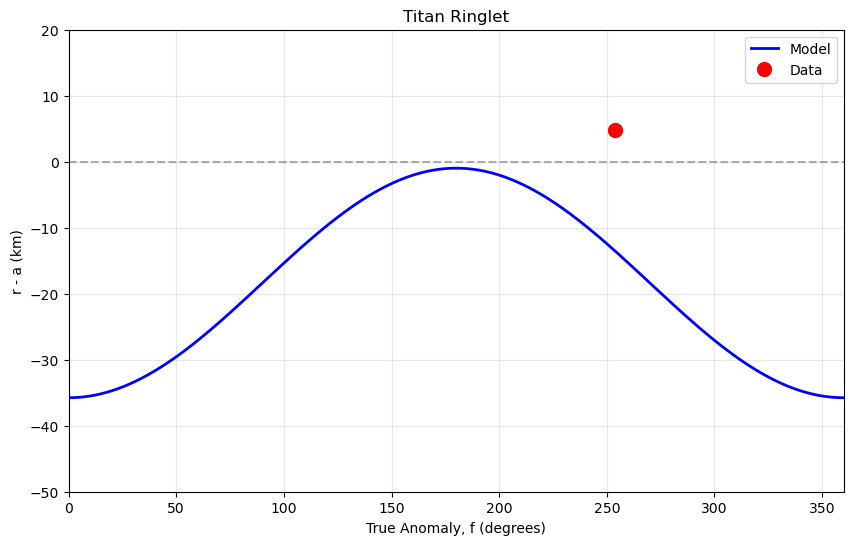

In [9]:
# This section plots both the model and our single value. Assuming whats next is to plot each data point and then fit the data points?
plt.figure(figsize=(10, 6))
plt.plot(true_anomaly_deg_model, model_radii - a, 'b-', linewidth=2, label='Model')
plt.plot(true_anomaly, radii - a, 'ro', markersize=10, label='Data')
plt.xlabel('True Anomaly, f (degrees)')
plt.ylabel('r - a (km)')  # Change y-label
plt.title('Titan Ringlet')
plt.xlim(0, 360)
plt.ylim(-50, 20)  # Set y-limits to see the variation
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)  # Add zero line
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()